# Going through LangGraph How-to tutorials
https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot

In [27]:
#import importlib
from _constants import LLM_CONFIGS
from langchain_ollama import ChatOllama
#importlib.reload(utils)

## Part 1: Building a Basic Chatbot with Memory and Human in the loop

In [28]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

NOTE: we need to play with this State class to see how we want to update state keys. Need to think about the format, input, output etc. any reducer functions. i.e add messages to list? or keeping track of ratings etc. 

In [17]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [18]:
graph_builder = StateGraph(State)

added human in the loop tool

In [19]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [20]:
tools = [human_assistance]

we want to now add a chatbot node

In [21]:
# from langchain.chat_models import init_chat_model

#llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")
llm = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"],
    #streaming=True,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    #return {"messages": [llm.invoke(state["messages"])]}
    return {"messages": message}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

add tool node

In [8]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

In [9]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END) #optional


add memory

In [10]:
memory = MemorySaver()

In [11]:
#graph = graph_builder.compile() #without memory
graph = graph_builder.compile(checkpointer=memory)


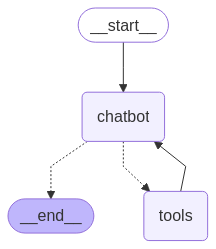

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [28]:
def run_stream(thread_to_use: dict):
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
            #stream_graph_updates(user_input)
            stream_graph_updates(user_input, thread_to_use)
        #stream_graph_updates(user_input, config_thread2)
        except:
            # fallback if input() is not available
            user_input = "What do you know about LangGraph?"
            print("User: " + user_input)
            stream_graph_updates(user_input, thread_to_use)
            #stream_graph_updates(user_input, config_thread2)
            #stream_graph_updates(user_input)
            break

In [16]:
config_thread1 = {"configurable": {"thread_id": "1"}}

In [17]:
# run_stream(config_thread1) # not running stream yet


Note: instead of input stream u can define user input

In [ ]:
user_input = "Hi there! My name is Will."

config_thread2 = {"configurable": {"thread_id": "2"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_thread2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. Is there something I can help you with, or would you like to chat for a bit?


In [17]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_thread2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Will, I'm a large language model, I don't have personal memories, but I'll do my best to recall our conversation. However, since this is the start of our conversation, we're essentially starting from scratch. Would you like to talk about something specific or just see where the conversation takes us?


In [18]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {'configurable': {"thread_id": "3"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm a large language model, I don't have personal memories or the ability to recall individual users' names. Each time you interact with me, it's a new conversation and I don't retain any information from previous chats.

However, I can help you find ways to stay organized and remember important details, such as sending yourself reminders or using a note-taking app to keep track of our conversations (although I won't be able to recall specific conversations in the future). Would you like some suggestions on how to do that?


Get state's snapshot based on config

In [20]:
snapshot = graph.get_state(config_thread2)
snapshot


StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='24140ba2-142f-47a0-aeaf-d81114d9e36f'), AIMessage(content="Hello Will! It's nice to meet you. Is there something I can help you with, or would you like to chat for a bit?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-05T22:59:18.012232Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1307566584, 'load_duration': 32223417, 'prompt_eval_count': 33, 'prompt_eval_duration': 488920000, 'eval_count': 30, 'eval_duration': 785840417, 'model_name': 'llama3.2'}, id='run--e48d975e-1cc3-4f94-92ff-1e3fe71ee11f-0', usage_metadata={'input_tokens': 33, 'output_tokens': 30, 'total_tokens': 63}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='c2364ce9-b5d2-42cc-be2b-d05607ab1ab7'), AIMessage(content="Will, I'm a large language model, I don't have personal memories, but I'll do my 

In [21]:
snapshot.next #empty because reached end of graph

()

# Part 4: Human in the loop

In [19]:
#user_input = "Hi there! My name is Will."
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"

config_thread = {"configurable": {"thread_id": "4"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_thread,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (730efdde-b49f-4aac-8775-10457c8c360b)
 Call ID: 730efdde-b49f-4aac-8775-10457c8c360b
  Args:
    query: Expert guidance for building an AI agent


In [20]:
snapshot = graph.get_state(config_thread)
snapshot.next

('tools',)

In [21]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config_thread, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (730efdde-b49f-4aac-8775-10457c8c360b)
 Call ID: 730efdde-b49f-4aac-8775-10457c8c360b
  Args:
    query: Expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

It seems like we've requested assistance from the experts, and they've recommended using LangGraph for building an AI agent.

To implement a basic autonomous agent using Python, I can provide some sample code:
```python
import random
import time

class AutonomousAgent:
    def __init__(self):
        self.actions = ['move_forward', 'turn_left', 'turn_right']
        self.current_action = 

Note: for some reason can't get run_stream to work with this

In [32]:
#run_stream(config_thread1)

# Part 5: Customizing a State

In [33]:
class BirthdayState(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [71]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance_with_birthday(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [72]:
#tools_bday = [human_assistance_with_birthday]
tools = [human_assistance_with_birthday] #this must be called tools, calling it anything else messes up everything

llm = ChatOllama(model=LLM_CONFIGS["llama3.2"]["model"])
llm_with_tools = llm.bind_tools(tools)


def chatbot_birthday(state: State):
    message = llm_with_tools.invoke(state["messages"])
    #print(message)
    assert len(message.tool_calls) <= 1
    return {"messages": message}


birthday_graph_builder = StateGraph(BirthdayState)
birthday_graph_builder.add_node("birthday_chatbot", chatbot_birthday)

#birthday_tool_node = ToolNode(tools=tools)
tool_node = ToolNode(tools=tools)
birthday_graph_builder.add_node("tools", tool_node)

birthday_graph_builder.add_conditional_edges(
    "birthday_chatbot",
    tools_condition, #customize tools_condition
    # {
    #     # If it returns 'action', route to the 'tools' node
    #     "action": "birthday_tool",
    #     # If it returns '__end__', route to the end
    #     "__end__": "__end__",
    # },
)

birthday_graph_builder.add_edge("tools", "birthday_chatbot")
birthday_graph_builder.add_edge(START, "birthday_chatbot")

memory_birthday = MemorySaver()
birthday_graph = birthday_graph_builder.compile(checkpointer=memory_birthday)

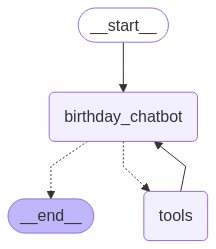

In [73]:
from IPython.display import Image, display

try:
    display(Image(birthday_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [74]:
user_input = (
    "When was LangGraph was released? When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "6"}}

events = birthday_graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

When was LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  human_assistance_with_birthday (04ace0c8-3de4-4a65-9d1e-abd2717d5b35)
 Call ID: 04ace0c8-3de4-4a65-9d1e-abd2717d5b35
  Args:
    birthday: null
    name: LangGraph release date


In [75]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = birthday_graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance_with_birthday (04ace0c8-3de4-4a65-9d1e-abd2717d5b35)
 Call ID: 04ace0c8-3de4-4a65-9d1e-abd2717d5b35
  Args:
    birthday: null
    name: LangGraph release date
================================= Tool Message =================================
Name: human_assistance_with_birthday

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

The LangGraph library was released on January 17, 2024.


In [76]:
snapshot = birthday_graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [79]:
snapshot.values

{'messages': [HumanMessage(content='When was LangGraph was released? When you have the answer, use the human_assistance tool for review.', additional_kwargs={}, response_metadata={}, id='615295e5-1986-46d4-a7e6-b995c9c23ae3'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-05T23:53:41.401245Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2657694125, 'load_duration': 1004070333, 'prompt_eval_count': 188, 'prompt_eval_duration': 851703375, 'eval_count': 30, 'eval_duration': 800465416, 'model_name': 'llama3.2'}, id='run--ea44117d-916c-448a-96db-c25368ffa6ac-0', tool_calls=[{'name': 'human_assistance_with_birthday', 'args': {'birthday': 'null', 'name': 'LangGraph release date'}, 'id': '04ace0c8-3de4-4a65-9d1e-abd2717d5b35', 'type': 'tool_call'}], usage_metadata={'input_tokens': 188, 'output_tokens': 30, 'total_tokens': 218}),
  ToolMessage(content="Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}",

In [80]:
birthday_graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02a0c6-b224-6028-8004-6b0ce6001f77'}}

In [81]:
snapshot = birthday_graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

In [ ]:
LLM_CONFIGS["llama3.2"]["model"]
llm = ChatOllama(LLM_CONFIGS["llama3.2"]["model"])


TypeError: BaseModel.__init__() takes 1 positional argument but 2 were given

In [23]:
llm 

ChatOllama(model='llama3.2')

In [3]:
from pydantic import BaseModel
from langgraph.prebuilt import create_react_agent

model = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)

class WeatherResponse(BaseModel):
    conditions: str
    
def get_weather(city: str) -> str:  
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

agent = create_react_agent(
    model=model,  
    tools=[get_weather],  
    prompt="You are a weather news reporter. Present the weather as if in a newscast. But output just one word at the end." ,
    response_format=WeatherResponse
)

# Run the agent
response = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

response["structured_response"]

WeatherResponse(conditions='partly cloudy')

In [4]:
response["messages"]

[HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='87e1fef1-f6fc-4ab8-9cef-3f5de01a640e'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-06T17:43:48.414205Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1381127791, 'load_duration': 32397375, 'prompt_eval_count': 184, 'prompt_eval_duration': 899002916, 'eval_count': 17, 'eval_duration': 447425792, 'model_name': 'llama3.2'}, id='run--98760988-1912-40ca-bd86-74a6b3e604c0-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': '137360da-8d06-449d-af7e-33805cee6279', 'type': 'tool_call'}], usage_metadata={'input_tokens': 184, 'output_tokens': 17, 'total_tokens': 201}),
 ToolMessage(content="It's always sunny in sf!", name='get_weather', id='c8296110-80a9-41af-b8ed-025e9987fa1c', tool_call_id='137360da-8d06-449d-af7e-33805cee6279'),
 AIMessage(content='Current weather conditions in San Francisco:\n\nPartly cl

In [29]:
from pydantic import BaseModel
from langgraph.prebuilt import create_react_agent

model = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)

class ReviewResponse(BaseModel):
    rating: int
    summary: str
    
def get_success_study_from_db(drug_name: str) -> str:
    """Retrieve successful studies from our curated database."""
    return f"a similar drug to {drug_name} was successful in previous studies."

def get_clinical_trails_from_api(drug_name: str) -> str:
    """Get any failed clinical trials related to this drug using the API."""
    return f"{drug_name} resulted in some terminated clinical studies."
    
def get_failed_study(drug_name: str) -> str:  
    """Get any failed studies for a given drug name."""
    return f"{drug_name} is a viable solution as a monoclonal antibody!"

user_prompt ="This proposed FDA label describes Respilimab, a humanized monoclonal antibody targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies."

rating_system_message = "You are a FDA regulatory reviewer. Rate the proposal from 1 to 10 in terms how well it passes the regulatory check and if it will be successful. Choose which tool to call either the curated database with success studies or the clinical trials api for failed studies and provide an explanation of why it may or not be successful based on retrieval from the curated database for successful studies or retrieval from the clinical trials API for failed trials that you know."
rating_agent = create_react_agent(
    model=model,  
    #tools=[get_failed_study], 
    tools = [get_clinical_trails_from_api, get_success_study_from_db], 
    prompt= rating_system_message,
    response_format=ReviewResponse
)


class FeedbackResponse(BaseModel):
    bulleted_list: str
    mechanistic_risk_summary: str 
    biomarker_assessment_summary: str
    endpoint_alignment_summary: str 
    safety_summary: str
    alternative_approach: str
    overall_summary: str
    
feedback_system_message = "You are an expert regulatory critiquer. \
                            Given the risk assessment and rating, propose \
                                changes and explain why to make these changes to improve the original proposal.\
                                Also provide an alternative approach for how they can rework their proposal to a different population or other strategies you can think of for better success \
                                    Give the final result in bullet points summary for each of these categories. \
                                    1) Mechanistic Risk 2) Biomarker Asessment 3) Endpoint Alignment 4) Safety."

# Run the agent
response = rating_agent.invoke(
    {"messages": [{"role": "user", "content": user_prompt}]}
)

def get_rating_results():
    """ Return the response from the previous agent, of a rating and summary of the original proposal."""
    return response['structured_response']

feedback_agent = create_react_agent(
    model=model,  
    tools=[get_rating_results],  
    prompt= feedback_system_message,
    response_format=FeedbackResponse
)

# Run the agent
response_2 = feedback_agent.invoke(
    {"messages": [{"role": "user", "content": user_prompt}]}
)


class WriterResponse(BaseModel):
    new_proposal_in_paragraph_form: str
    summary_of_changes: str
    
writer_system_message = "You are an expert FDA regulatory writer. \
                            Given the feedback for approval, rewrite the original proposal with the appropriate changes. \
                                Provide a 200-word new proposal well-written incorporating the changes"

# # Run the agent
# response = rating_agent.invoke(
#     {"messages": [{"role": "user", "content": user_prompt}]}
# )

def get_feedback():
    """ Return the feedback from the previous agent, of specific improvements to make to the original proposal."""
    return response_2['messages'][-1].content

writer_agent = create_react_agent(
    model=model,  
    tools=[get_feedback],  
    prompt= writer_system_message,
    response_format=WriterResponse
)

# Run the agent
response_3 = writer_agent.invoke(
    {"messages": [{"role": "user", "content": user_prompt}]}
)


In [30]:
response

{'messages': [HumanMessage(content='This proposed FDA label describes Respilimab, a humanized monoclonal antibody targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies.', additional_kwargs={}, response_metadata={}, id='36ee5032-c463-4dea-b8ae-279c086e118a'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-07T16:26:19.828737Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1956868583, 'load_duration': 34781958, 'prompt_eval_count': 379, 'prompt_eval_duration': 1390387875, 'eval_count': 19, 'eval_duration': 528992209, 'model_name': 'llama3.2'}, id='run--5d8a578d-4587-4713-a1c7-4a023dfd5e36-0', tool_calls=[{'name': 'get_success_study_from_db', 'args': {'drug_name': 'Respilimab'}, 'id': '8

In [31]:
print(response['messages'][-1].content)

Based on the information from the curated database for successful studies (Respilimab), it appears that this drug has shown promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma.

However, I also retrieved some failed trial data from the clinical trials API (Reslizumab). Although Reslizumab is a similar drug to Respilimab, it was not successful in showing significant benefits in a specific trial. The failed trial highlights some potential risks or limitations of monoclonal antibody therapy for asthma.

Given this mixed information, I would rate the proposed FDA label for Respilimab as an 8 out of 10 in terms of regulatory check and success. While there is evidence to support its effectiveness, there are also some concerns that need to be addressed. A more thorough review of the data and additional studies would likely be necessary to fully assess the safety and efficacy of Respilimab.

To improve the rating, I would sugges

In [32]:
print('Rating:', response['structured_response'].rating)
print('Summary:', response['structured_response'].summary)

Rating: 8
Summary: Respilimab shows promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma, but there are some concerns that need to be addressed, such as potential risks associated with monoclonal antibody therapy.


In [33]:
response_2

{'messages': [HumanMessage(content='This proposed FDA label describes Respilimab, a humanized monoclonal antibody targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies.', additional_kwargs={}, response_metadata={}, id='24f2af6c-4d72-4a99-9aa3-25453286709e'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-07T16:26:40.492787Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1375458250, 'load_duration': 12476458, 'prompt_eval_count': 330, 'prompt_eval_duration': 832664417, 'eval_count': 20, 'eval_duration': 529130750, 'model_name': 'llama3.2'}, id='run--b1484e01-c986-4191-9ec2-f36e50d0c231-0', tool_calls=[{'name': 'get_rating_results', 'args': {'id': ' RespilimabFDAlabelreview'}, 'id': '7

In [34]:
print(response_2['messages'][-1].content)

Based on the rating of 8 out of 10, here are proposed changes to improve the original proposal:

**Mechanistic Risk:**

* Add more detailed information on the potential immunogenicity and potential for antibody-dependent cellular cytotoxicity (ADCC) associated with monoclonal antibody therapy.
* Include data on the pharmacokinetics and pharmacodynamics of Respilimab in patients with eosinophilic asthma.

Proposed changes:
- "Warning: Immune-mediated reactions, including hypersensitivity reactions, may occur. Monitor for signs and symptoms."
- "Monitoring: Regularly monitor for ADCC effects, such as fatigue, headaches, and muscle pain."

**Biomarker Assessment:**

* Include more biomarkers to assess the efficacy of Respilimab in patients with eosinophilic asthma.
* Add information on the relationship between IL-13 levels and lung function.

Proposed changes:
- "Efficacy: Monitor changes in fractional exhaled nitric oxide (FeNO) and IL-5 levels to assess lung inflammation."
- "Clinical s

In [35]:
print(response_2['structured_response'])


bulleted_list='Respilimab shows promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma. However, there are some concerns that need to be addressed, such as potential risks associated with monoclonal antibody therapy.' mechanistic_risk_summary='' biomarker_assessment_summary='' endpoint_alignment_summary='' safety_summary='' alternative_approach='' overall_summary='Respilimab shows promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma, but there are some concerns that need to be addressed, such as potential risks associated with monoclonal antibody therapy. Consider targeting alternative drivers of eosinophilic asthma or combination therapies.'


In [36]:
print("Bullets:",response_2['structured_response'].bulleted_list)
print("MR:",response_2['structured_response'].mechanistic_risk_summary)
print("BM:",response_2['structured_response'].biomarker_assessment_summary)
print("EA:",response_2['structured_response'].endpoint_alignment_summary)
print("SA:",response_2['structured_response'].safety_summary)
print("AA:",response_2['structured_response'].alternative_approach)
print("Overall:",response_2['structured_response'].overall_summary)

Bullets: Respilimab shows promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma. However, there are some concerns that need to be addressed, such as potential risks associated with monoclonal antibody therapy.
MR: 
BM: 
EA: 
SA: 
AA: 
Overall: Respilimab shows promise in improving lung function and reducing exacerbations in patients with moderate-to-severe eosinophilic asthma, but there are some concerns that need to be addressed, such as potential risks associated with monoclonal antibody therapy. Consider targeting alternative drivers of eosinophilic asthma or combination therapies.


In [37]:
print(response_3)

{'messages': [HumanMessage(content='This proposed FDA label describes Respilimab, a humanized monoclonal antibody targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies.', additional_kwargs={}, response_metadata={}, id='d9416288-04b4-4e79-97e4-897dcbe7c7d4'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-07T16:27:09.836797Z', 'done': True, 'done_reason': 'stop', 'total_duration': 957454791, 'load_duration': 12231416, 'prompt_eval_count': 268, 'prompt_eval_duration': 672153959, 'eval_count': 11, 'eval_duration': 272259958, 'model_name': 'llama3.2'}, id='run--fedb3bc0-eab0-42b5-88cb-4a6981746ad7-0', tool_calls=[{'name': 'get_feedback', 'args': {}, 'id': '6a163677-0202-425c-8adb-b0666d737f01', 'typ

In [38]:
print(response_3['messages'][-1].content)

Here is a rewritten 200-word proposal incorporating the changes:

Respilimab, a humanized monoclonal antibody targeting IL-13, has been shown to improve lung function and reduce exacerbations in patients with moderate-to-severe eosinophilic asthma. The proposed label will outline the dosing regimen (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes.

**Mechanistic Risk:**

Respilimab may induce immune-mediated reactions, including hypersensitivity reactions, which should be monitored for signs and symptoms. The pharmacokinetics and pharmacodynamics of Respilimab in patients with eosinophilic asthma will also be discussed.

**Biomarker Assessment:**

Efficacy will be assessed by monitoring changes in fractional exhaled nitric oxide (FeNO) and IL-5 levels, which are biomarkers of lung inflammation. The relationship between IL-13 levels and lung function will also be explored.

**Endpoint Alignment:**

In addition to lung function and exacerbation reduction, quality of l

In [39]:
print(response_3['structured_response'])

new_proposal_in_paragraph_form="Respilimab is a humanized monoclonal antibody targeting IL-13 for the treatment of moderate-to-severe eosinophilic asthma. The proposed label will outline the dosing regimen, safety data, and trial outcomes, including improved lung function and reduced exacerbations in patients uncontrolled on standard inhaled therapies. Mechanistic risk factors include potential immune-mediated reactions, infusion reactions, and antibody-dependent cellular cytotoxicity. Efficacy will be assessed by monitoring changes in fractional exhaled nitric oxide (FeNO) and IL-5 levels, as well as the relationship between IL-13 levels and lung function. Endpoint alignment includes quality of life assessment using the EQ-5D-3L questionnaire and standardized scales for exercise capacity and lung function measurement. Safety considerations include common side effects such as injection site reactions, headache, and fatigue, with dose adjustment or discontinuation recommended in case of

In [40]:
print("NEW PROPOSAL")
print(response_3['structured_response'].new_proposal_in_paragraph_form)
print("summary of changes")
print(response_3['structured_response'].summary_of_changes)


NEW PROPOSAL
Respilimab is a humanized monoclonal antibody targeting IL-13 for the treatment of moderate-to-severe eosinophilic asthma. The proposed label will outline the dosing regimen, safety data, and trial outcomes, including improved lung function and reduced exacerbations in patients uncontrolled on standard inhaled therapies. Mechanistic risk factors include potential immune-mediated reactions, infusion reactions, and antibody-dependent cellular cytotoxicity. Efficacy will be assessed by monitoring changes in fractional exhaled nitric oxide (FeNO) and IL-5 levels, as well as the relationship between IL-13 levels and lung function. Endpoint alignment includes quality of life assessment using the EQ-5D-3L questionnaire and standardized scales for exercise capacity and lung function measurement. Safety considerations include common side effects such as injection site reactions, headache, and fatigue, with dose adjustment or discontinuation recommended in case of severe infusion re

notes: it called both tools and tried to find them which is useful. need to work on renaming variables as well as structured response to really get what we want in a systematic matter, can also write a script to run with 3 threads for example to test parallely and join results together. 